# Optimization test functions

This notebook containts our experiements with forward gradient vs. reverse mode AD for the beale and rosenbrock functions, two popular optimization testing functions. All parameters used are taken from Gradients without backpropagation: https://arxiv.org/pdf/2202.08587.pdf

#### Setup

In [4]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.7 MB 50 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220610+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220610+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220610+cpu which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.4 MB 1.6 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0.dev20220610+cpu
    Uninstalling torch-1.13.0.dev20220610+cpu:
      Successfully uninstalled torch-1.13.0.dev20220610+cpu


--> Restarting colab instance


{'restart': True, 'status': 'ok'}

In [2]:
!git clone https://github.com/benjaminrike1/forward_gradient

fatal: destination path 'forward_gradient' already exists and is not an empty directory.


In [3]:
cd forward_gradient

/content/forward_gradient/forward_gradient


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from optim_functions import beale, rosenbrock
from helpers import optimize
from plot_helpers import plot_loss, plot_countour, plot_contour2
from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD
from models import Net, ConvNet, LogisticRegression

torch.manual_seed(0)


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Test functions

We start by runnng Beale for both forward gradient and reverse gradient.

[2.043822765350342, 1.9382550716400146, 1.837282419204712, 1.7408695220947266, 1.6489794254302979, 1.5615671873092651, 1.4785752296447754, 1.3999309539794922, 1.325545310974121, 1.2553107738494873, 1.1891028881072998, 1.126781702041626, 1.0681936740875244, 1.0131750106811523, 0.9615526795387268, 0.9131495952606201, 0.8677856922149658, 0.8252813816070557, 0.785459578037262, 0.7481474876403809, 0.7131785154342651, 0.6803929805755615, 0.6496393084526062, 0.6207746267318726, 0.5936645269393921, 0.5681837201118469, 0.5442155599594116, 0.5216514468193054, 0.5003916621208191, 0.48034340143203735, 0.461421400308609, 0.4435468316078186, 0.4266475737094879, 0.41065651178359985, 0.3955126106739044, 0.38115888833999634, 0.36754339933395386, 0.35461780428886414, 0.34233784675598145, 0.3306623101234436, 0.3195534944534302, 0.3089762330055237, 0.29889777302742004, 0.28928834199905396, 0.28011977672576904, 0.27136626839637756, 0.263003408908844, 0.25500908493995667, 0.24736221134662628, 0.240043312311

/content/forward_gradient/forward_gradient/helpers.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return losses, [element.item() for element in np.asarray(grads).ravel()], [element.item() for element in np.asarray(parameters).ravel()]
/content/forward_gradient/forward_gradient/helpers.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return losses, [element

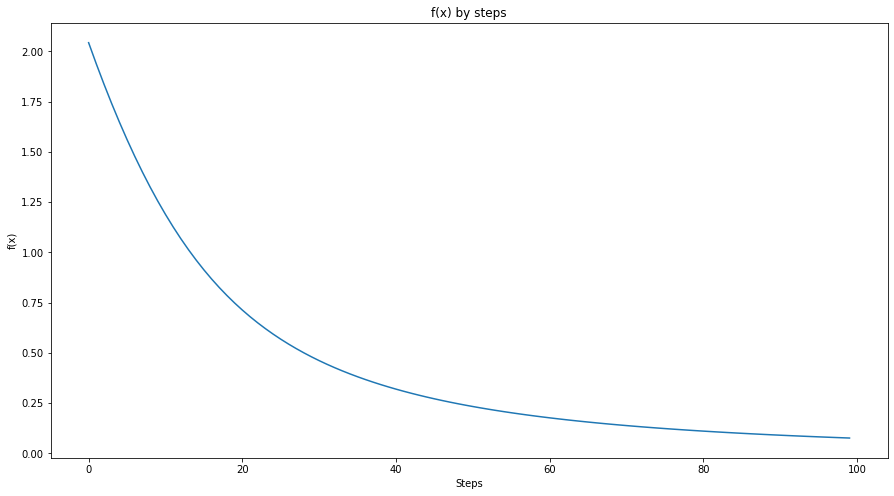

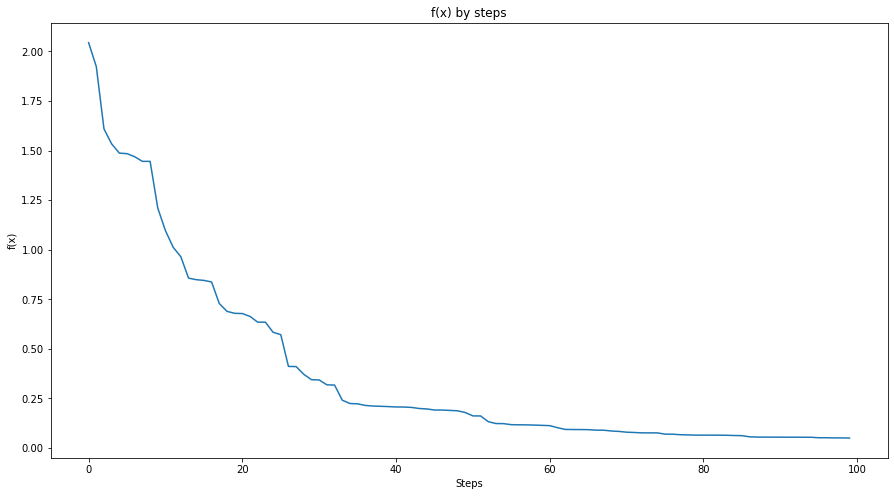

In [5]:
torch.manual_seed(0)
steps = 100

# defining parameters
primal0 = torch.randn(1) # x input
primal1 = torch.randn(1) # y input
x = primal0.clone()
x.requires_grad_()
y = primal1.clone()
y.requires_grad_()
params = (x, y)

# finding optimum with backprop
loss_rev, grad_rev, params_rev = optimize(beale, params, steps, optimizer="SGD", lr=0.01)
plot_loss(loss_rev, steps)

# finding optimum with forward gradient
loss_fwd, grad_fwd, params_rev = optimize(beale, (primal0, primal1), steps, lr=0.01)
plot_loss(loss_fwd, steps)

We repeat the procedure for Rosenbrock.

[3.020430564880371, 1.6810952425003052, 0.9961113929748535, 0.6319505572319031, 0.4331777095794678, 0.32264286279678345, 0.26033496856689453, 0.2248486429452896, 0.20446914434432983, 0.1926785409450531, 0.18580463528633118, 0.18175983428955078, 0.17934928834438324, 0.17788544297218323, 0.1769711822271347, 0.17637653648853302, 0.17596793174743652, 0.17566774785518646, 0.17543084919452667, 0.17523087561130524, 0.17505256831645966, 0.17488691210746765, 0.17472872138023376, 0.17457498610019684, 0.17442387342453003, 0.17427441477775574, 0.17412596940994263, 0.17397817969322205, 0.1738308221101761, 0.17368385195732117, 0.17353710532188416, 0.17339061200618744, 0.17324432730674744, 0.17309823632240295, 0.1729523092508316, 0.17280657589435577, 0.17266102135181427, 0.1725156456232071, 0.17237043380737305, 0.17222538590431213, 0.17208053171634674, 0.17193584144115448, 0.17179131507873535, 0.17164698243141174, 0.17150279879570007, 0.17135879397392273, 0.17121495306491852, 0.17107127606868744, 0.1

/content/forward_gradient/forward_gradient/helpers.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return losses, [element.item() for element in np.asarray(grads).ravel()], [element.item() for element in np.asarray(parameters).ravel()]
/content/forward_gradient/forward_gradient/helpers.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return losses, [element

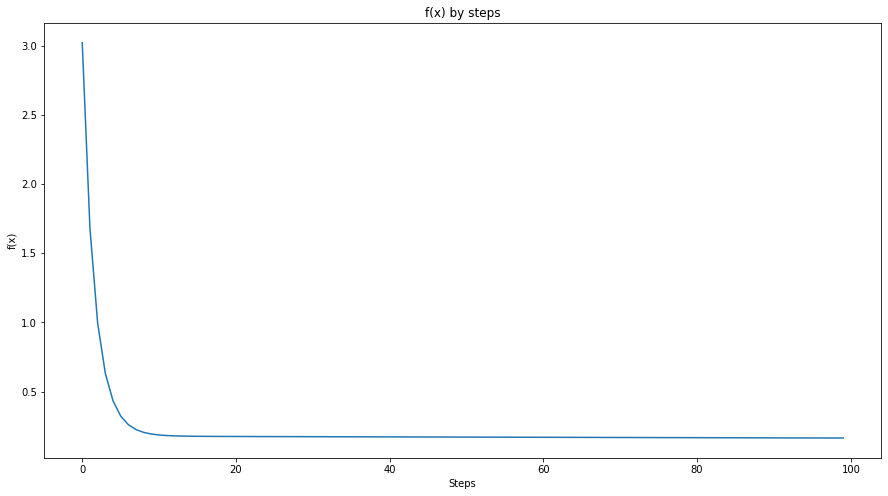

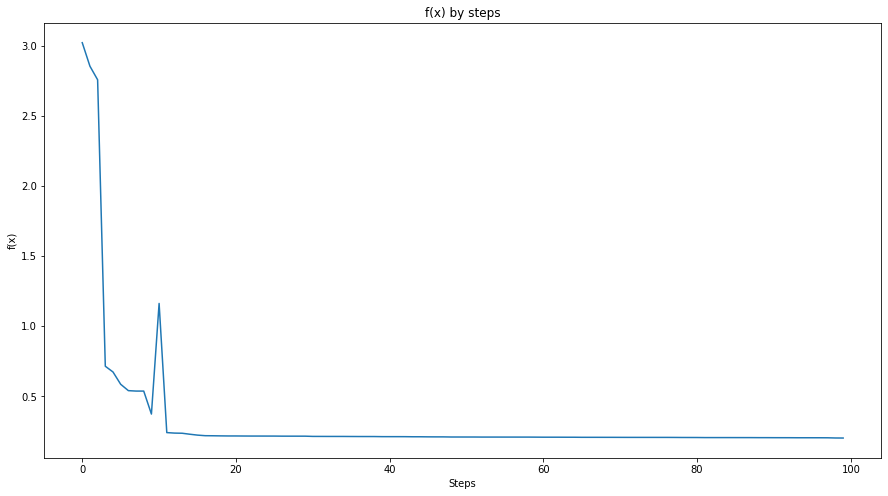

In [13]:
torch.manual_seed(1)
steps = 100

# defining parameters
primal0 = torch.randn(1) # x input
primal1 = torch.randn(1) # y input
x = primal0.clone()
x.requires_grad_()
y = primal1.clone()
y.requires_grad_()
params = (x, y)

# finding optimum with backprop
loss_rev, grad_rev, params_rev = optimize(rosenbrock, params, steps, optimizer="SGD", lr=5e-4)
plot_loss(loss_rev, steps)

# finding optimum with forward gradient
loss_fwd, grad_fwd, params_rev = optimize(rosenbrock, (primal0, primal1), steps, lr=5e-4)
plot_loss(loss_fwd, steps)

#### Gradient inspection

We so make some visualizations to better understand how the gradients behave for the two functions.

/content/forward_gradient/forward_gradient/helpers.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return losses, [element.item() for element in np.asarray(grads).ravel()], [element.item() for element in np.asarray(parameters).ravel()]
/content/forward_gradient/forward_gradient/helpers.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return losses, [element

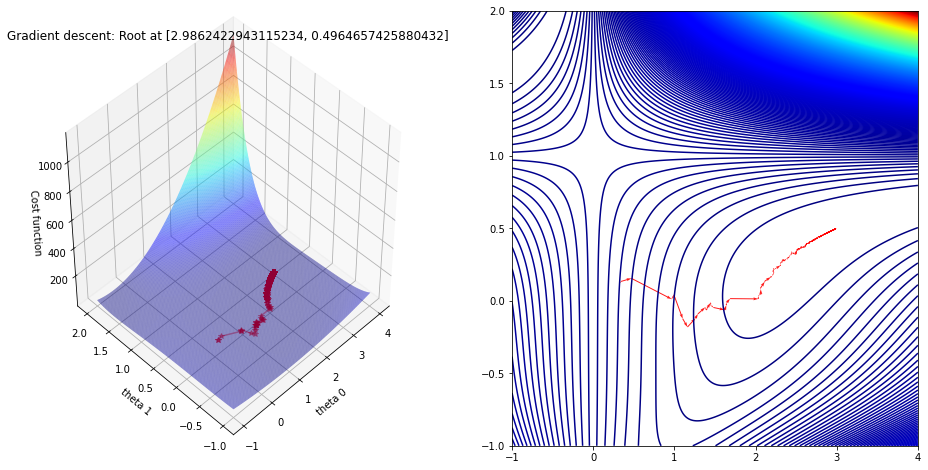

In [16]:
steps = 1000
torch.manual_seed(42)
primal0 = torch.randn(1) # x input
primal1 = torch.randn(1) # y input

x = primal0.clone()
x.requires_grad_()
y = primal1.clone()
y.requires_grad_()
params = (x, y)

loss_fwd, grad_fwd, params_fwd = optimize(beale, (primal0, primal1), steps, lr=0.01)
plot_contour2(loss_fwd, params_fwd, beale, (-1,4), (-1,2))

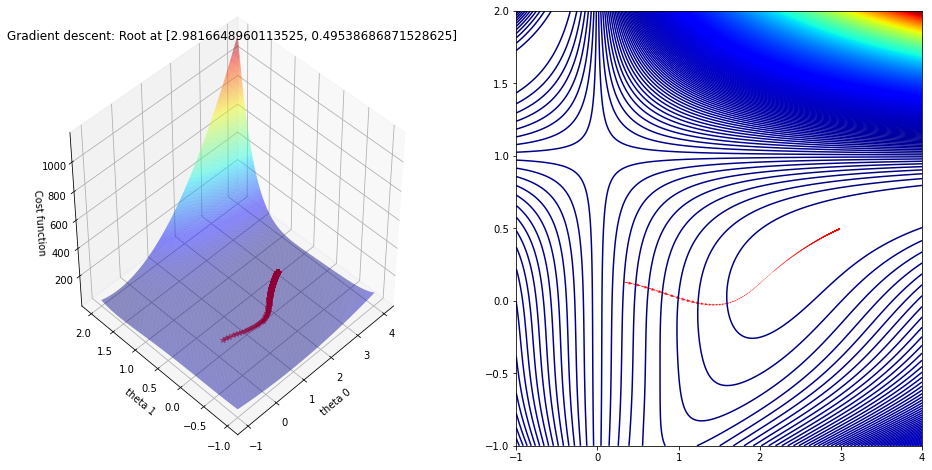

In [17]:
loss_rev, grad_rev, params_rev = optimize(beale, params, steps, optimizer="SGD", lr=0.01)
plot_contour2(loss_rev, params_rev, beale, (-1,4), (-1,2))

/content/forward_gradient/forward_gradient/helpers.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return losses, [element.item() for element in np.asarray(grads).ravel()], [element.item() for element in np.asarray(parameters).ravel()]
/content/forward_gradient/forward_gradient/helpers.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return losses, [element

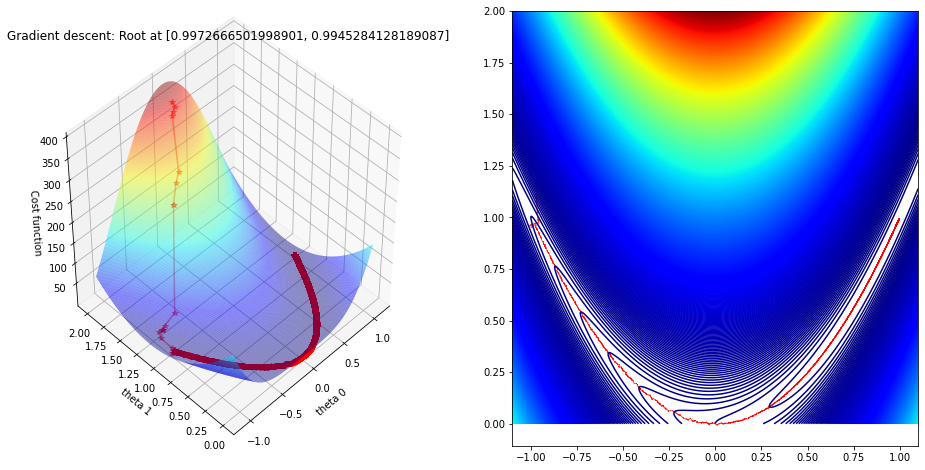

In [18]:
steps = 25000
torch.manual_seed(9)
primal0 = torch.randn(1) # x input
primal1 = torch.randn(1) # y input

x = primal0.clone()
x.requires_grad_()
y = primal1.clone()
y.requires_grad_()
params = (x, y)

loss_fwd, grad_fwd, params_fwd = optimize(rosenbrock, (primal0, primal1), steps, lr=5e-4)
plot_contour2(loss_fwd, params_fwd, rosenbrock, (-1.1,1.1), (0,2))

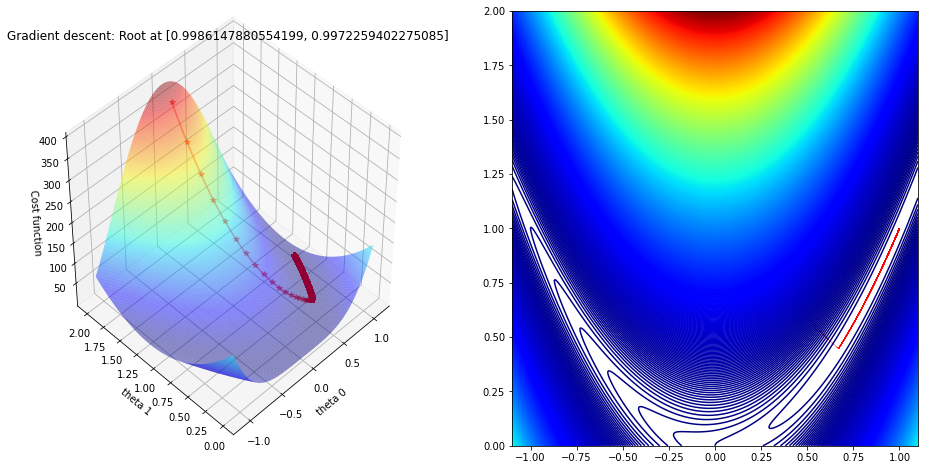

In [19]:
torch.manual_seed(9)
primal0 = torch.randn(1) # x input
primal1 = torch.randn(1) # y input

x = primal0.clone()
x.requires_grad_()
y = primal1.clone()
y.requires_grad_()
params = (x, y)

loss_rev, grad_rev, params_rev = optimize(rosenbrock, params, steps, optimizer="SGD", lr=5e-4)
plot_contour2(loss_rev, params_rev, rosenbrock, (-1.1,1.1), (0,2))

## Properties of the forward gradient

We then turn to studying the properties of the forward gradient. Especially, we are interested in seeing the variance of the forward gradient. Even though it is an unbiased estimator for the real gradient, it will have much greater variance than an SGD gradient.

First we reconstruct the experiment from figure 1 in the paper. I.e., we evaluate the gradient of the Beale function at x=1.5, y=-0.1.

Real gradient: [-3.434, -0.808] 


In [58]:
# first, we calculate the variance for 10 steps

primals = (torch.tensor([1.5]), torch.tensor([-0.1])) # x=1.5, y=0.1
tangents = []
fwd_grads = []
steps=10
for i in range(steps):
  tangent = (torch.randn(1), torch.randn(1)) #perturbation vector
  f, jvp = ft.jvp(beale, primals, tangent) # jacobian-vector product
  fwd_grads.append([jvp.mul(t).item() for t in tangent]) #forward gradient
  tangents.append([t.item() for t in tangent])

# calculating mean and standard deviation
avg_grad = np.mean(fwd_grads, axis=0)
std_grad = np.std(fwd_grads, axis=0)
avg1 = avg_grad[0]
avg2 = avg_grad[1]


In [59]:
print(f"Average gradient: [{format(avg1, '.2f')}, {format(avg2,'.2f')}], Standard deviation: {std_grad}")
print(f"Real gradient: [-3.434, -0.808]")

Average gradient: [-2.25, -0.01], Standard deviation: [2.28097961 1.91860223]
Real gradient: [-3.434, -0.808]


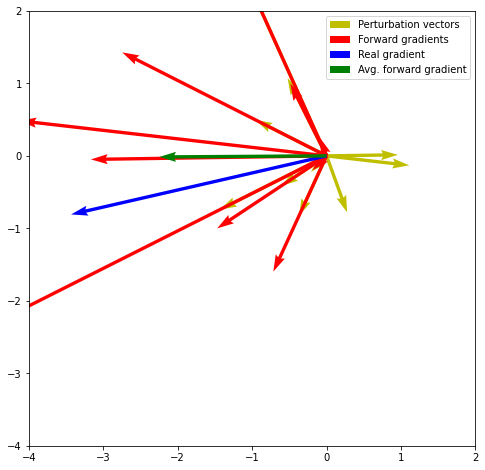

In [61]:
# visulaizing the relationship between the forward gradients and the real gradient
plt.figure(figsize=(8,8))
V = np.asarray(tangents)
W = np.asarray(fwd_grads)
origin = np.zeros((2,steps))# origin point
optimal1, optimal2 = -3.434, -0.808
plt.quiver(*origin, V[:,0], V[:,1], color='y', angles='xy', scale_units='xy', scale=1, label="Perturbation vectors")
plt.quiver(*origin, W[:,0], W[:,1], color='r', label="Forward gradients", angles='xy', scale_units='xy', scale=1)
plt.quiver(0,0, optimal1, optimal2, color='b', label="Real gradient", angles='xy', scale_units='xy', scale=1)
plt.quiver(0,0, avg1, avg2, color='g', label='Avg. forward gradient', angles='xy', scale_units='xy', scale=1)

plt.legend()
plt.xlim(-4, 2)
plt.ylim(-4, 2)
plt.show()

In [62]:
# then, the variance for 100 steps

primals = (torch.tensor([1.5], requires_grad=True), torch.tensor([-0.1], requires_grad=True)) # x=1.5, y=0.1
tangents = []
fwd_grads = []
steps=100
for i in range(steps):
  tangent = (torch.randn(1), torch.randn(1)) #perturbation vector
  f, jvp = ft.jvp(beale, primals, tangent) # jacobian-vector product
  fwd_grads.append([jvp.mul(t).item() for t in tangent]) #forward gradient
  tangents.append([t.item() for t in tangent])

# calculating mean and standard deviation
avg_grad = np.mean(fwd_grads, axis=0)
std_grad = np.std(fwd_grads, axis=0)
avg1 = avg_grad[0]
avg2 = avg_grad[1]

In [63]:
print(f"Average forward gradient: [{format(avg1, '.2f')}, {format(avg2,'.2f')}], Standard deviation: {std_grad}")
print(f"Real gradient: [-3.434, -0.808]")

Average forward gradient: [-3.67, -1.23], Standard deviation: [6.46769274 4.75845739]
Real gradient: [-3.434, -0.808]


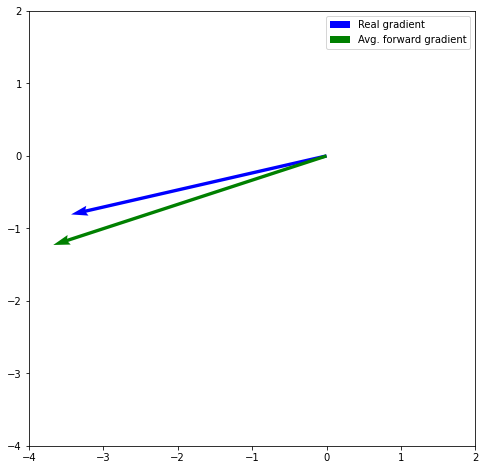

In [65]:
# visulaizing the relationship between the forward gradients and the real gradient
plt.figure(figsize=(8,8))
V = np.asarray(tangents)
W = np.asarray(fwd_grads)
plt.quiver(0,0, optimal1, optimal2, color='b', label="Real gradient", angles='xy', scale_units='xy', scale=1)
plt.quiver(0,0, avg1, avg2, color='g', label='Avg. forward gradient', angles='xy', scale_units='xy', scale=1)

plt.legend()
plt.xlim(-4, 2)
plt.ylim(-4, 2)
plt.show()

In [66]:
# finally, we calculate the variance for 1000 steps

primals = (torch.tensor([1.5], requires_grad=True), torch.tensor([-0.1], requires_grad=True)) # x=1.5, y=0.1
tangents = []
fwd_grads = []
steps=1000
for i in range(steps):
  tangent = (torch.randn(1), torch.randn(1)) #perturbation vector
  f, jvp = ft.jvp(beale, primals, tangent) # jacobian-vector product
  fwd_grads.append([jvp.mul(t).item() for t in tangent]) #forward gradient
  tangents.append([t.item() for t in tangent])

# calculating mean and standard deviation
avg_grad = np.mean(fwd_grads, axis=0)
std_grad = np.std(fwd_grads, axis=0)
avg1 = avg_grad[0]
avg2 = avg_grad[1]

In [68]:
print(f"Average forward gradient: [{format(avg1, '.2f')}, {format(avg2,'.2f')}], Standard deviation: {std_grad}")
print(f"Real gradient: [-3.434, -0.808]")

Average forward gradient: [-3.38, -0.82], Standard deviation: [4.91651661 3.6000319 ]
Real gradient: [-3.434, -0.808]


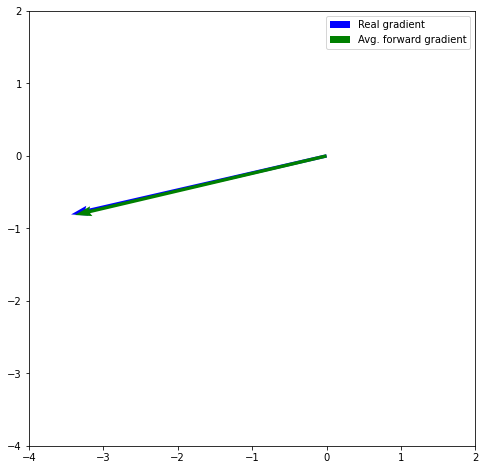

In [69]:
# visulaizing the relationship between the forward gradients and the real gradient
plt.figure(figsize=(8,8))
V = np.asarray(tangents)
W = np.asarray(fwd_grads)
plt.quiver(0,0, optimal1, optimal2, color='b', label="Real gradient", angles='xy', scale_units='xy', scale=1)
plt.quiver(0,0, avg1, avg2, color='g', label='Avg. forward gradient', angles='xy', scale_units='xy', scale=1)

plt.legend()
plt.xlim(-4, 2)
plt.ylim(-4, 2)
plt.show()